In [8]:
from langgraph.graph import START, StateGraph, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [13]:
class TweeetState(TypedDict):

    topic : str
    tweet : str
    eval : Literal['approved', 'needs improvement']
    feedback : str
    iter : int
    max_iter : int

In [14]:
class TweetEval(BaseModel):
    eval : Literal['approved', 'needs improvement'] = Field(description="Final evaluation result.")
    feedback : str = Field(description='feedback for the tweet.')

In [17]:
load_dotenv()

model = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")
llm = model.with_structured_output(TweetEval)

In [15]:
def gen_tweet(state : TweeetState):
    message = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and ilarious tweet on the topic : {state['topic']}
Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humour, irony, sarcasm, or cultural referances.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    res = model.invoke(message).content
    return {"tweet" : res}

In [18]:
def eval_tweet(state: TweeetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    
    res = llm.invoke(messages)

    return {'eval': res.eval, "feedback" : res.feedback }

In [19]:
def optimize(state : TweeetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    res = model.invoke(messages).content
    iter = state['iter'] + 1

    return {"tweet": res, "iter": iter}


In [20]:
def check(state : TweeetState):
    if state['eval'] == "approved" or state['iter'] >= state['max_iter']:
        return "approved"
    else:
        return "needs_improvement"

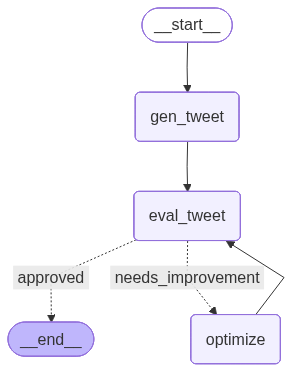

In [24]:
graph = StateGraph(TweeetState)

graph.add_node("gen_tweet", gen_tweet)
graph.add_node("eval_tweet", eval_tweet)
graph.add_node("optimize", optimize)

graph.add_edge(START, "gen_tweet")
graph.add_edge("gen_tweet", "eval_tweet")

graph.add_conditional_edges("eval_tweet", check, {'approved': END, "needs_improvement": "optimize"})

graph.add_edge("optimize", "eval_tweet")

workflow = graph.compile()
workflow

In [33]:
initial_state = {
    "topic": "dad joke on a dad joke",
    "iter" : 1,
    "max_iter" : 5
}

workflow.invoke(initial_state)

{'topic': 'dad joke on a dad joke',
 'tweet': 'My dad just delivered a dad joke *about* the last dad joke someone told. He said, "That joke was so old, it needed a nap *and* a Werther\'s Original." The silence was deafening. Peak dad-ception.',
 'eval': 'approved',
 'feedback': 'This tweet demonstrates strong originality by layering a dad joke within another dad joke, culminating in "dad-ception," which is a clever and relatable concept. The specific punchline, "That joke was so old, it needed a nap *and* a Werther\'s Original," is genuinely humorous and perfectly captures the essence of a classic, slightly out-of-touch dad joke. While a bit longer than some ultra-punchy tweets, its narrative structure is engaging and still concise enough to be scroll-stopping. The virality potential is high due to its relatability and the shareable nature of the specific joke and the "dad-ception" concept. The format is impeccable, adhering to all character limits and avoiding common pitfalls like Q&A